## Download image data and labels ##

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import tarfile
import random
import time
import glob
import json
from pathlib import Path

# Matplotlib for plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import patches

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import dentexmodel as dm
from dentexmodel.fileutils import FileOP
from dentexmodel.imageproc import ImageData

print(f'Project module version: {dm.__version__}')

Project module version: 0.0.post1.dev36+gb44e647.d20240101


In [2]:
# Path settings 
dentex_dir = os.path.join(os.environ['HOME'], 'data', 'dentex')
data_dir = os.path.join(dentex_dir, 'dentex_disease')
Path(data_dir).mkdir(parents=True, exist_ok=True)
image_dir = os.path.join(data_dir, 'quadrant-enumeration-disease', 'xrays')
url = 'https://dsets.s3.amazonaws.com/dentex/dentex-quadrant-enumeration-disease.tar.gz'
image_url_size = FileOP().file_size_from_url(url)
print(f'Dataset: {os.path.basename(url)} file size: {image_url_size/1024/1024:.2f} MiB')

Dataset: dentex-quadrant-enumeration-disease.tar.gz file size: 2047.89 MiB


In [3]:
# Download data
data_tar_file = FileOP().download_from_url(url, download_dir=data_dir)
if os.path.exists(data_tar_file):
    with tarfile.open(data_tar_file, 'r') as tar:
        tar.extractall(data_dir)
file_list = glob.glob(os.path.join(image_dir, '*.png'))

Extracting from .gz archive.
Uncompressed output file exists: /home/andreas/data/dentex/dentex_disease/dentex-quadrant-enumeration-disease.tar. Skipping.


In [4]:
# Create a data frame with the image file paths
file_name_list = [os.path.basename(file) for file in file_list]
im_number_list = [int(os.path.splitext(file)[0].rsplit('_', maxsplit=1)[-1]) for file in file_name_list]
files = pd.DataFrame({'image_number': im_number_list,
                      'file_name': file_name_list,
                      'file_path': file_list}).\
                sort_values(by='image_number', ascending=True).reset_index(drop=True)

display(files.head())

,image_number,file_name,file_path
0,0,train_0.png,/home/andreas/data/dentex/dentex_disease/quadr...
1,1,train_1.png,/home/andreas/data/dentex/dentex_disease/quadr...
2,2,train_2.png,/home/andreas/data/dentex/dentex_disease/quadr...
3,3,train_3.png,/home/andreas/data/dentex/dentex_disease/quadr...
4,4,train_4.png,/home/andreas/data/dentex/dentex_disease/quadr...


In [6]:
# Load the annotation file
annotation_file = glob.glob(os.path.join(data_dir, 'quadrant-enumeration-disease', '*.json'))
if len(annotation_file)>0:
    annotation_file = annotation_file[0]
    print(f'Annotation data file: {annotation_file}')
    with open(annotation_file, 'r') as file:
        js = json.load(file)
    js_im = js.get('images')
    js_an = js.get('annotations')
    print(f'Found {len(js_an)} annotations for {len(js_im)} images.')
else:
    annotation_file = None

# Add image ids to the files data frame
js_im_df = pd.DataFrame(js_im).\
                merge(files, on='file_name', how='inner').\
                sort_values(by='id', ascending=True).\
                reset_index(drop=True).\
                rename(columns={'id': 'image_id'}).\
                drop(['height', 'width'], axis=1)
display(js_im_df.head())
print(js_im_df.shape)

Annotation data file: /home/andreas/data/dentex/dentex_disease/quadrant-enumeration-disease/train_quadrant_enumeration_disease.json
Found 3529 annotations for 705 images.


,image_id,file_name,image_number,file_path
0,1,train_673.png,673,/home/andreas/data/dentex/dentex_disease/quadr...
1,2,train_283.png,283,/home/andreas/data/dentex/dentex_disease/quadr...
2,3,train_435.png,435,/home/andreas/data/dentex/dentex_disease/quadr...
3,4,train_95.png,95,/home/andreas/data/dentex/dentex_disease/quadr...
4,5,train_475.png,475,/home/andreas/data/dentex/dentex_disease/quadr...


(705, 4)


### Extract position bounding boxes and disease labels from the annotation file ###

In [7]:
# Categories in annotation file
# Tooth quadrant position
quadrant_df = pd.DataFrame(js.get('categories_1'))
print('Tooth quadrants:')
display(quadrant_df)
print()
# Tooth number in quadrant
num_df = pd.DataFrame(js.get('categories_2'))
print('Tooth numbers:')
display(num_df)
print()
# Finally, the disease classifications
cl_df = pd.DataFrame(js.get('categories_3'))
print('Disease classifications:')
display(cl_df)

Tooth quadrants:


,id,name,supercategory
0,0,1,1
1,1,2,2
2,2,3,3
3,3,4,4



Tooth numbers:


,id,name,supercategory
0,0,1,1
1,1,2,2
2,2,3,3
3,3,4,4
4,4,5,5
5,5,6,6
6,6,7,7
7,7,8,8



Disease classifications:


,id,name,supercategory
0,0,Impacted,Impacted
1,1,Caries,Caries
2,2,Periapical Lesion,Periapical Lesion
3,3,Deep Caries,Deep Caries


### Transfer annotations from json file into a data frame ###

In [8]:
# Loop over the annotations
an_df_list = []
for idx, an_dict in enumerate(js_an):
    if (idx + 1) % 500 == 0:
        print(f'Annotation {idx + 1} / {len(js_an)}')
    image_id = an_dict.get('image_id')
    id_df = js_im_df.loc[js_im_df['image_id'] == image_id]
    # Extract the annotations for this annotation id
    quadrant = quadrant_df.loc[quadrant_df['id'] == an_dict.get('category_id_1'), 'name'].values[0]
    position = num_df.loc[num_df['id'] == an_dict.get('category_id_2'), 'name'].values[0]
    id_df = id_df.assign(quadrant=quadrant,
                         position=position,
                         label=cl_df.loc[cl_df['id'] == an_dict.get('category_id_3'), 'name'].values[0],
                         area=[an_dict.get('area')],
                         bbox=[an_dict.get('bbox')],
                         box_name=(f'{os.path.splitext(id_df["file_name"].values[0])[0]}_'
                                   f'{idx}_{quadrant}_{position}'))    
    an_df_list.append(id_df)
an_df = pd.concat(an_df_list, axis=0, ignore_index=True)

# Add the number of annotations to each image
n_annotations = an_df[['file_name', 'label']].\
                groupby('file_name').count().\
                reset_index(drop=False).\
                rename(columns={'label': 'annotations'})

an_df = an_df.merge(n_annotations, on='file_name', how='inner').\
                sort_values(by='image_id', ascending=True).\
                reset_index(drop=True)

print()
display(an_df.head())

Annotation 500 / 3529
Annotation 1000 / 3529
Annotation 1500 / 3529
Annotation 2000 / 3529
Annotation 2500 / 3529
Annotation 3000 / 3529
Annotation 3500 / 3529



,image_id,file_name,image_number,file_path,quadrant,position,label,area,bbox,box_name,annotations
0,1,train_673.png,673,/home/andreas/data/dentex/dentex_disease/quadr...,4,8,Impacted,39683,"[542.0, 698.0, 220.0, 271.0]",train_673_0_4_8,13
1,1,train_673.png,673,/home/andreas/data/dentex/dentex_disease/quadr...,4,1,Periapical Lesion,21469,"[1288.3116883116884, 723.3766233766233, 62.337...",train_673_12_4_1,13
2,1,train_673.png,673,/home/andreas/data/dentex/dentex_disease/quadr...,3,2,Periapical Lesion,22286,"[1405.1948051948052, 724.6753246753246, 75.324...",train_673_10_3_2,13
3,1,train_673.png,673,/home/andreas/data/dentex/dentex_disease/quadr...,3,7,Caries,42235,"[1806.0, 696.0, 237.0, 308.0]",train_673_9_3_7,13
4,1,train_673.png,673,/home/andreas/data/dentex/dentex_disease/quadr...,3,6,Caries,46556,"[1667.0, 723.0, 237.0, 356.0]",train_673_8_3_6,13


### Plot some images with annotations ###

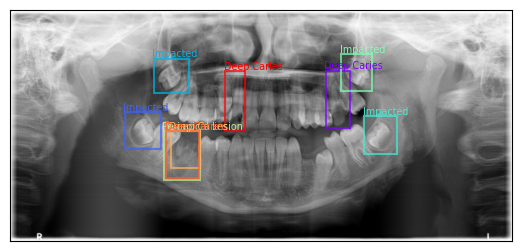

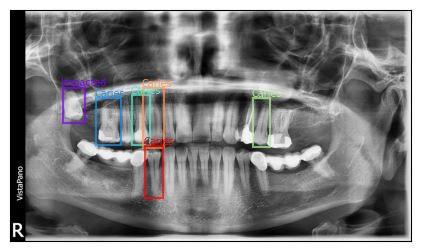

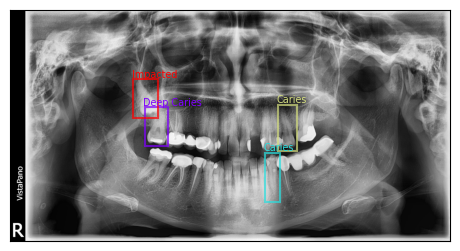

In [9]:
# Show an xray image with bounging boxes
file_name_list = ['train_267.png', 'train_269.png', 'train_270.png']
for file_name in file_name_list:
    an_file_df = an_df.loc[(an_df['file_name'] == file_name)] 
    #                        (an_df['position'] == '6') &
    #                        (an_df['quadrant'] == '4')]
    
    file = os.path.join(image_dir, file_name)
    im = ImageData().load_image(file)
    
    # Create a list of colors for the rectangles
    color = cm.rainbow(np.linspace(0, 1, len(an_file_df)))
    color_list = [color[c] for c in range(len(color))]
    text_offset_xy = (-10, -10)
    
    # Create the figure and show the panoramic x-ray image
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.imshow(im)
    
    # Loop over the bounding boxes
    for i, idx in enumerate(an_file_df.index): 
    
        box_df = an_file_df.loc[an_file_df.index==idx]
        
        box = box_df['bbox'].values[0]
        bbox = box[0], box[1], box[0] + box[2], box[1] + box[3]
        label = box_df['label'].values[0]
        
        
        rect = patches.Rectangle(xy=(box[0], box[1]), width=box[2], height=box[3], 
                                         linewidth=1.5, edgecolor=color_list[i], 
                                         facecolor='none', alpha=0.7)
        ax.add_patch(rect)
        ax.text(box[0]+text_offset_xy[0], box[1]+text_offset_xy[1]+i, label, color=color_list[i], fontsize='x-small')
        ax.set(xticks=[], yticks=[])
    
    plt.show()

In [10]:
# Save the data frame with the file paths and annotations
df_file_name = 'dentex_disease_dataset.parquet'
df_file = os.path.join(dentex_dir, df_file_name)
an_df.to_parquet(df_file)
print(f'Annotation data frame saved: {df_file}')

Annotation data frame saved: /home/andreas/data/dentex/dentex_disease_dataset.parquet
